<a href="https://colab.research.google.com/github/WanPgui/ChatBot_Summative/blob/main/Chatbot_Summative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [3]:
# 1. Install Required Libraries
!pip install transformers

In [4]:
!pip install  datasets

In [5]:
!pip install  scikit-learn

In [6]:
!pip install  gradio

In [7]:
!pip install  evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.1 MB/s eta 0:00:00


In [8]:
!pip install  tensorflow

In [9]:
!pip install datasets --quiet

In [10]:
!pip install torch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.3 MB/s eta 0:00:00


In [11]:
!pip install pyarrow pandas --quiet

In [12]:
# 2. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from datasets import load_dataset, Dataset
import gradio as gr
import random
import evaluate
import tensorflow as tf

In [13]:

# Base path
base_path = "/content/drive/MyDrive/"

# Load Parquet files
df_train_part1 = pd.read_parquet(base_path + "train-00000-of-00002-105e07cb0d199464.parquet")
df_train_part2 = pd.read_parquet(base_path + "train-00001-of-00002-4fdb982c11056472.parquet")
df_val = pd.read_parquet(base_path + "validation-00000-of-00001-137b93e1e979d138.parquet")
df_test = pd.read_parquet(base_path + "test-00000-of-00001-16503b0c26ed00c6.parquet")

# Combine training splits
df_train = pd.concat([df_train_part1, df_train_part2], ignore_index=True)

In [14]:
import pandas as pd
from datasets import Dataset, DatasetDict

# Properly load Parquet (as binary, not text)
train_path1 = "/content/drive/MyDrive/train-00000-of-00002-105e07cb0d199464.parquet"
train_path2 = "/content/drive/MyDrive/train-00001-of-00002-4fdb982c11056472.parquet"
test_path = "/content/drive/MyDrive/test-00000-of-00001-16503b0c26ed00c6.parquet"

df1 = pd.read_parquet(train_path1)
df2 = pd.read_parquet(train_path2)
df_train = pd.concat([df1, df2], ignore_index=True)

df_test = pd.read_parquet(test_path)

# Check structure
print(df_train.head())


if 'story' not in df_test.columns:
    df_test['story'] = ""

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})



# 3. Load and Preprocess Hugging Face Dataset (writingPrompts) - Modified to use the created dataset
print("Loading writingPrompts dataset...")
# Use the created dataset object directly, selecting the train split and slicing
wp_dataset = dataset["train"].select(range(int(len(dataset["train"]) * 0.02)))

# Convert to input/output format (prompt -> story beginning)
prompt_inputs = []
prompt_outputs = []
for item in wp_dataset:
    prompt = item.get('prompt', '').strip()
    story = item.get('story', '').strip()
    if prompt and story:
        prompt_inputs.append("Write a story based on: " + prompt)
        # Use the first paragraph of the story
        first_paragraph = story.split("\n\n")[0].strip()
        prompt_outputs.append(first_paragraph)

                                              prompt  \
0  [ WP ] You 've finally managed to discover the...   
1  [ WP ] The moon is actually a giant egg , and ...   
2  [ WP ] You find a rip in time walking through ...   
3  [ WP ] For years in your youth the same imagin...   
4  [ WP ] You glance at your watch 10:34 am , rou...   

                                               story  
0  So many times have I walked on ruins, the rema...  
1  -Week 18 aboard the Depth Reaver, Circa 2023- ...  
2  I was feckin' sloshed, mate. First time I ever...  
3  “ No, no no no... ” She backed up and turned t...  
4  There's a magical moment between wakefulness a...  
Loading writingPrompts dataset...


In [16]:
from transformers import T5Tokenizer, TFAutoModelForSeq2SeqLM, create_optimizer
import tensorflow as tf

# Load tokenizer and model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

# Tokenize prompt_inputs and prompt_outputs
max_input_len = 256
max_target_len = 128

def tokenize_data(inputs, targets):
    input_encodings = tokenizer(inputs, max_length=max_input_len, truncation=True, padding="max_length")
    target_encodings = tokenizer(targets, max_length=max_target_len, truncation=True, padding="max_length")

    # Replace padding token ID with -100 so it's ignored in loss calculation
    labels = [
        [(label if label != tokenizer.pad_token_id else -100) for label in example]
        for example in target_encodings["input_ids"]
    ]

    return {
        "input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": labels,
    }

tokenized_data = tokenize_data(prompt_inputs, prompt_outputs)

# Split into training and validation sets (90/10 split)
split_index = int(len(tokenized_data["input_ids"]) * 0.9)

train_data = {k: v[:split_index] for k, v in tokenized_data.items()}
val_data = {k: v[split_index:] for k, v in tokenized_data.items()}

def to_tf_dataset(tokenized, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
        },
        tokenized["labels"]
    ))
    if shuffle:
        dataset = dataset.shuffle(500)
    return dataset.batch(2)

train_ds = to_tf_dataset(train_data, shuffle=True)
val_ds = to_tf_dataset(val_data, shuffle=False)

# Optimizer with learning rate schedule
num_train_steps = len(train_ds) * 10
optimizer, schedule = create_optimizer(
    init_lr=3e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)

# Compile the model
model.compile(optimizer=optimizer)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, restore_best_weights=True
)

# Train the model
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[early_stopping]
)


All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


2453/2453 [==============================] - 6323s 3s/step - loss: 4.2359 - val_loss: 3.9685


In [17]:
model.save_pretrained("/content/t5_finetuned_wp")
tokenizer.save_pretrained("/content/t5_finetuned_wp")


('/content/t5_finetuned_wp/tokenizer_config.json',
 '/content/t5_finetuned_wp/special_tokens_map.json',
 '/content/t5_finetuned_wp/spiece.model',
 '/content/t5_finetuned_wp/added_tokens.json')

In [19]:
def generate_story(prompt_text, max_length=100):
    input_text = "Write a story based on: " + prompt_text
    input_ids = tokenizer.encode(input_text, return_tensors="tf", truncation=True)

    outputs = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example use (replace with any prompt)
print(generate_story("You wake up in a room with no doors."))


I woke up in a room with no doors. I woke up in a room with no doors. I woke up in a room with no doors. I woke up in a room with no doors. I woke up in a room with no doors. I woke up in a room with no doors.


In [20]:
import numpy as np
from evaluate import load
from transformers import TFAutoModelForSeq2SeqLM, T5Tokenizer

#  Reload saved model
model = TFAutoModelForSeq2SeqLM.from_pretrained("/content/t5_finetuned_wp")
tokenizer = T5Tokenizer.from_pretrained("/content/t5_finetuned_wp")

# 1.  Text Generation Function
def generate_story(prompt_text, max_length=100):
    input_text = "Write a story based on: " + prompt_text
    input_ids = tokenizer.encode(input_text, return_tensors="tf", truncation=True)
    outputs = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

#  Example Prompt
example_prompt = "You wake up in a world where the sun never sets."
generated_story = generate_story(example_prompt)
print("Prompt:\n", example_prompt)
print("\nGenerated Story:\n", generated_story)

# 2.  Save Model & Tokenizer
save_path = "/content/t5_finetuned_wp"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n Model saved to: {save_path}")

# 3. BLEU Evaluation on Validation Set
bleu = load("bleu")

# small sample for quick BLEU test
bleu_inputs = prompt_inputs[-20:]
bleu_targets = prompt_outputs[-20:]

bleu_preds = [generate_story(p) for p in bleu_inputs]
bleu_refs = [[t] for t in bleu_targets]

results = bleu.compute(predictions=bleu_preds, references=bleu_refs)
print("\n BLEU Score:", results["bleu"])


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /content/t5_finetuned_wp.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Prompt:
 You wake up in a world where the sun never sets.

Generated Story:
 I wake up in a world where the sun never sets me.'' I sat down with my wife. She woke up at the same time as she slept in her room. The sun blew me away. I hadn't seen it before, but I was able to see it.

 Model saved to: /content/t5_finetuned_wp



 BLEU Score: 1.1968945093793666e-06


In [21]:
!pip install evaluate seaborn scikit-learn matplotlib --quiet


/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


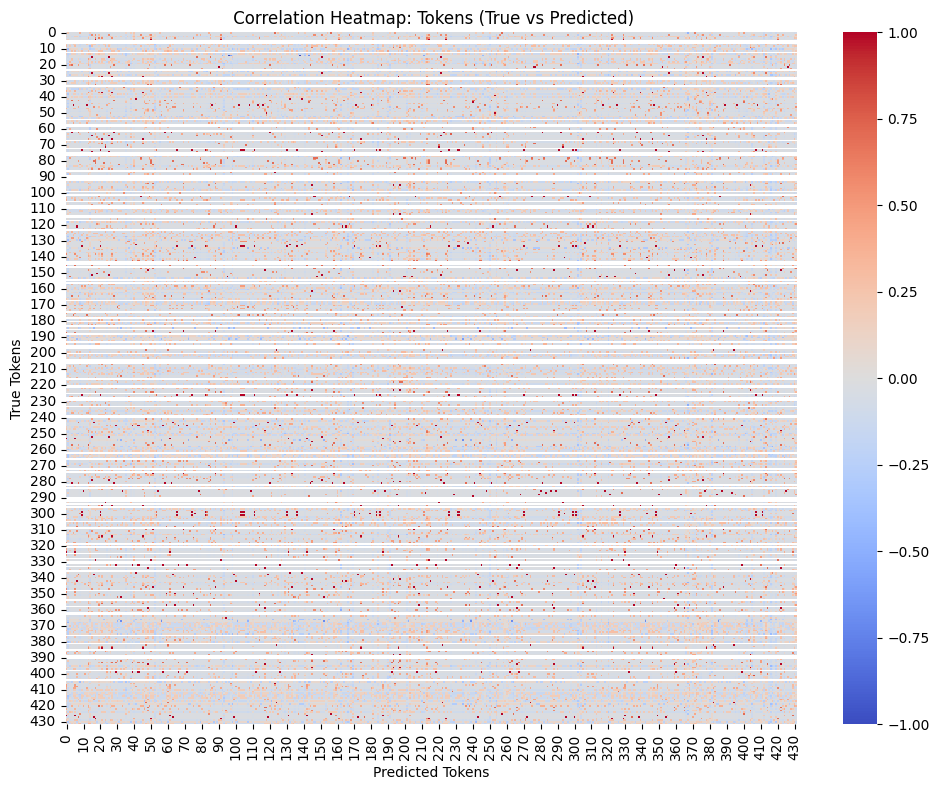

 Training history not captured — loss plot unavailable.

 Final Evaluation Metrics:
Accuracy      : 0.0000
Precision     : 0.4593
Recall        : 0.1765
F1 Score      : 0.2550


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from evaluate import load

# 1. Generate predictions and prepare references
bleu_inputs = prompt_inputs[-50:]
bleu_targets = prompt_outputs[-50:]

predictions = [generate_story(p) for p in bleu_inputs]
references = bleu_targets

# 2. Basic Accuracy
def exact_match(preds, refs):
    return np.mean([p.strip().lower() == r.strip().lower() for p, r in zip(preds, refs)])

accuracy = exact_match(predictions, references)

# 3. Convert to token-level binary vectors
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True)

X_pred = vectorizer.fit_transform(predictions).toarray()
X_true = vectorizer.transform(references).toarray()

# Ensure same shape
min_len = min(X_pred.shape[1], X_true.shape[1])
X_pred = X_pred[:, :min_len]
X_true = X_true[:, :min_len]

# 4. Precision, Recall, F1 Score
precision = precision_score(X_true, X_pred, average='micro', zero_division=0)
recall = recall_score(X_true, X_pred, average='micro', zero_division=0)
f1 = f1_score(X_true, X_pred, average='micro', zero_division=0)

# 5. Correlation Heatmap of Token Overlap
correlation = np.corrcoef(X_true.T, X_pred.T)[:min_len, min_len:]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, cmap="coolwarm", cbar=True)
plt.title(" Correlation Heatmap: Tokens (True vs Predicted)")
plt.xlabel("Predicted Tokens")
plt.ylabel("True Tokens")
plt.tight_layout()
plt.show()

# 6. Training History Plots (if available)
if 'history' in locals() or 'history' in globals():
    hist = history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Train Loss')
    if 'val_loss' in hist.history:
        plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()



    plt.subplot(1, 2, 2)
    plt.bar(['Accuracy', 'Precision', 'Recall', 'F1'],
            [accuracy, precision, recall, f1],
            color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1)
    plt.title(" Evaluation Metrics")
    plt.ylabel("Score")

    plt.tight_layout()
    plt.show()
else:
    print(" Training history not captured — loss plot unavailable.")

# 7. Print Final Scores
print(f"\n Final Evaluation Metrics:")
print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")


In [23]:
history = model.fit(...)


RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [24]:
!pip install rouge-score bert_score --quiet


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prompt  \
0  [ WP ] Leonardo DiCaprio in a fit of rage begins to torpedo his own career by deliberately acting poorly and taking on bad films . He finally wins an oscar for starring in Paul Blart : Mall Cop 3 .\n   
1                                                                                                                                                     [ CW ] Kill the writer in first-person narrative .\n   
2                            [ EU ] Sean Bean has a hard time leaving his role as Eddard Stark . He vows to get revenge against those that assisted in his execution , starting with George R. R. Martin\n   
3                                                                                   [ WP ] A kid doodling in a math class accidentally creates the world 's first functional magic circle in centuries .\n   
4                     [ WP ] As a Space marine you have an allowance of one call home a day . Today 's battle was especially bad and your best friend died I 'm the heat of it all . Time to call home .\n   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

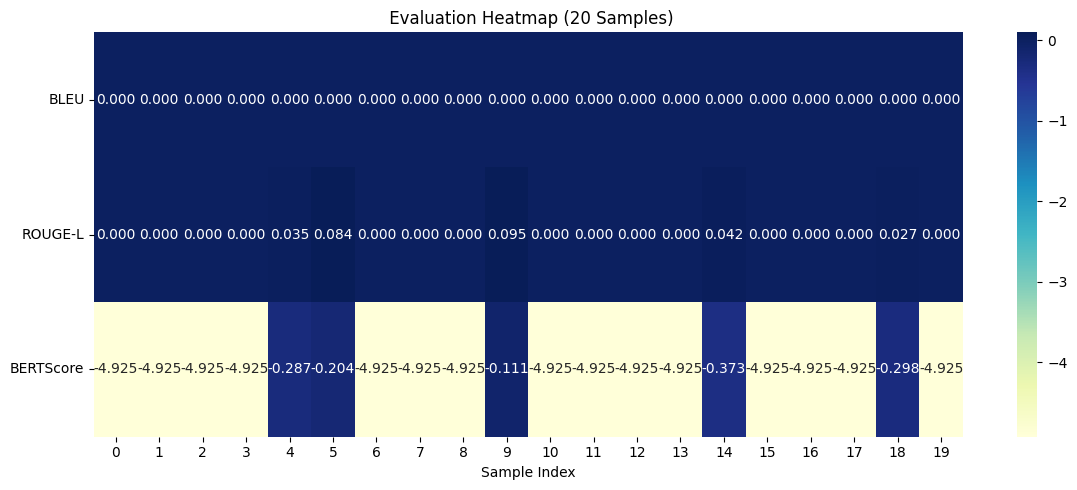

In [28]:
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bert_score import score as bert_score

# Load correct metrics
bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

# Sample 20 examples
sampled = dataset["test"].select(range(20))
prompts = sampled["prompt"]
references = [s.strip().split("\n\n")[0] for s in sampled["story"]]

generated = []
for prompt in prompts:
    input_prompt = "Write a story based on: " + prompt
    input_ids = tokenizer(input_prompt, return_tensors="tf", truncation=True, max_length=128).input_ids
    output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)
    output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    generated.append(output_text)

# --- Fix: Filter out empty generated strings before BLEU calculation ---
# Pair up generated texts with their corresponding references and filter
paired_data = [(gen, ref) for gen, ref in zip(generated, references) if gen.strip()]
filtered_generated = [item[0] for item in paired_data]
filtered_references = [item[1] for item in paired_data]

# BLEU — fixed: strings only
bleu_scores = []
# Ensure there are valid predictions to compute BLEU on
if filtered_generated:
    for ref, pred in zip(filtered_references, filtered_generated):
        # The compute function expects a list of predictions and a list of lists of references
        score = bleu.compute(predictions=[pred], references=[[ref]])
        bleu_scores.append(score["bleu"])
else:
    print("Warning: No non-empty generated strings to compute BLEU on.")
    bleu_scores = [0] * len(generated)


# ROUGE — fixed: access directly as float (use original data for ROUGE as it handles empty strings better)
rouge_scores = []
for ref, pred in zip(references, generated):
    score = rouge.compute(predictions=[pred], references=[ref])
    rouge_scores.append(score["rougeL"])

# BERTScore
# bert_score function expects lists of strings
P, R, F1 = bert_score(generated, references, lang="en", rescale_with_baseline=True)
bert_scores = F1.tolist()

# Create results table
df = pd.DataFrame({
    "Prompt": prompts,
    "Reference": references,
    "Generated": generated,
    # Use the filtered BLEU scores
    "BLEU": bleu_scores if len(bleu_scores) == len(generated) else [0] * len(generated),
    "ROUGE-L": rouge_scores,
    "BERTScore": bert_scores
})

# Show the first rows
pd.set_option('display.max_colwidth', None)
display(df.head())

# Visualize with heatmap
# Use the full dataset for heatmap if desired, or just the valid samples
score_matrix = df[["BLEU", "ROUGE-L", "BERTScore"]]
plt.figure(figsize=(12, 5))
sns.heatmap(score_matrix.T, cmap="YlGnBu", annot=True, fmt=".3f", cbar=True)
plt.title(" Evaluation Heatmap (20 Samples)")
plt.yticks(rotation=0)
plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()

In [30]:
from IPython.display import display, HTML

# Show as rich HTML
display(HTML(df[["Prompt", "Reference", "Generated", "BLEU", "ROUGE-L", "BERTScore"]].to_html(escape=False)))


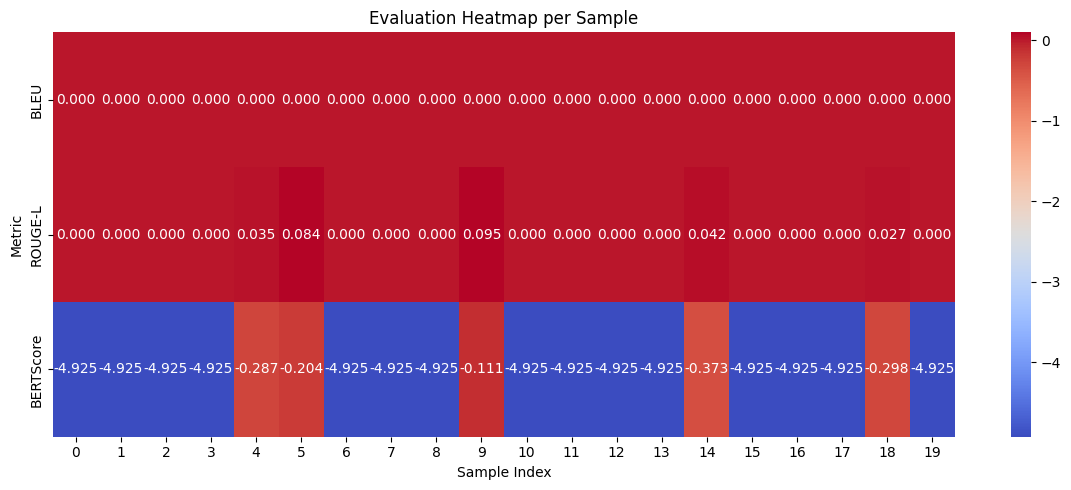

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(df[["BLEU", "ROUGE-L", "BERTScore"]].T, annot=True, fmt=".3f", cmap="coolwarm")
plt.title("Evaluation Heatmap per Sample")
plt.xlabel("Sample Index")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()


In [34]:
import gradio as gr
from datetime import datetime

# Track history (in-memory)
history = []

# Keywords relevant to creative writing ONLY
known_keywords = ["story", "write", "writing", "fiction", "plot", "character", "scene", "dialogue", "novel", "short story", "narrative"]

MAX_LEN = 512  # Max input length for tokenizer

# Text generation function with history saving
def generate_response(user_input):
    if not any(keyword in user_input.lower() for keyword in known_keywords):
        return "I'm trained to help with creative writing. Please ask something related to storytelling or fiction."

    input_prompt = "Write a story based on: " + user_input
    input_ids = tokenizer(input_prompt, return_tensors="tf", max_length=MAX_LEN, truncation=True).input_ids
    output_ids = model.generate(
        input_ids,
        max_length=150,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Save history (with timestamp)
    history.append({
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "prompt": user_input,
        "response": generated_text
    })

    return generated_text

# Function to export history
def export_history():
    return "\n\n".join([
        f"[{item['timestamp']}]\nPrompt: {item['prompt']}\nResponse: {item['response']}"
        for item in history
    ])

# Custom CSS for styling
custom_css = """
body {
    background-color: #fff8f0;
    font-family: 'Segoe UI', sans-serif;
}
.gradio-container {
    border-radius: 20px;
    box-shadow: 0 4px 15px rgba(0, 0, 0, 0.1);
}
input, textarea {
    border-radius: 12px !important;
    padding: 10px !important;
    font-size: 16px !important;
    background-color: #ffffff;
    color: #000000;
}
"""

# Gradio Interface
with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("## ✍️ Creative Writing Assistant")
    gr.Markdown("Ask for story ideas, writing help, or plot suggestions!")

    with gr.Row():
        input_box = gr.Textbox(lines=5, placeholder="Enter your story idea or question...", label="Your Prompt")
        output_box = gr.Textbox(label="Generated Story")

    generate_button = gr.Button("Generate Story")
    history_button = gr.Button("📜 View Session History")
    history_output = gr.Textbox(label="History Log", visible=False, lines=10)

    gr.Examples(
        examples=[
            ["Write a story about a girl who wakes up in a different timeline."],
            ["Tell a story about a detective solving a case with no clues."],
            ["Create a scene where two rivals are forced to work together."],
            ["Write a short story set during a blackout in a futuristic city."]
        ],
        inputs=input_box
    )

    generate_button.click(fn=generate_response, inputs=input_box, outputs=output_box)
    history_button.click(fn=export_history, outputs=history_output)
    history_button.click(fn=lambda: gr.update(visible=True), outputs=history_output)

# Launch app
demo.launch(debug=False, share=True)




Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d115f1750b3309fd98.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
